# 10. Introduction to Gibbs Sampling 

Gibbs sampling ({cite:t}gehmanbros1984) is a special case of Metropolis-Hastings where our proposal distribution comes from the full conditional distribution of the parameter. This allows us to remove the acceptance ratio calculation. The detailed balance property is satisfied because we are sampling exactly from the conditional distribution of each parameter in turn. The transition from one state to another and back has the same probability.

This makes Gibbs sampling very efficient, which is why BUGS (Bayesian inference Using Gibbs Sampling, {cite:t}BUGSoriginal) tries to use this algorithm as a first resort. But it only works if we can find these full conditionals. The lecture has some simple examples. You can also check out the [Gibbs handout](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit5/GIBBS.zip) created by Professor Vidakovic. 

I'm going to jump into a slightly more complicated example here, where we can only get the full conditionals for some of the parameters and have to include a Metropolis-Hastings step for one of them.

```{warning}
This page contains the answer to a supplementary exercise, specifically the 5.4 problem *Georgia Deaths from Kidney Cancer 1985-1989 by Counties.* If you want to try it yourself first, hold off on reading the rest of this page.
```

## Gibbs sampling with a Metropolis-Hastings step

The dataset (available [here](https://raw.githubusercontent.com/areding/6420-pymc/main/data/cheese.csv)) has the deaths from kidney cancer by Georgia county along with the population of each county. We're going to estimate the death rate for each county along with the all-Georgia death rate. This is our model:


$$
\begin{align*}
y_i &\sim Poi(\lambda_i n_i), i = 1, ..., m \\
\lambda_i &\sim Ga(\alpha, \beta), i = 1, ..., m \\
\alpha & \sim U(0, A) \\
\beta & \sim U(0, B)
\end{align*}
$$

$m = 159$ (number of counties)

The original answer has a typo here, 169 is not the correct number of counties.

$n = \sum_{i=1}^{k}$ (total Georgia population/100k)

We'll talk more about these kinds of hierarchical models in Unit 7—for now, let's focus on the the sampling algorithm.

### Finding the joint distribution

The Poisson PDF is:

$$\frac{\lambda^{y_i}_i \exp(-\lambda_i n_i)}{y_i!}$$

We're looking for the number of deaths per county, so $y_i$ is our "$k$" in the Poisson distribution, the number of occurences. The original example used $k$ to mean the number of counties, but I've replaced that with $m$ to avoid confusion here.

The Gamma PDF: 

$$\frac{\beta^\alpha}{\Gamma(\alpha)} \lambda_i^{\alpha - 1} \exp(-\beta \lambda_i)$$

The shape and rate parameters will be fit by the algorithm here; we aren't specifying them like we've done in the past. We will sample them from the uniform distribution with bounds of 0 to A or B. We constrain them to be greater than 0, because that's is required for both Gamma parameters.

Uniform PDFs on alpha and beta:

$$\frac{1}{A} \mathbf{1}(0 \le \alpha \le A) , \frac{1}{B} \mathbf{1}(0 \le \beta \le B)$$

Then our joint distribution is:

$$f(y, \lambda, \alpha, \beta) = \prod_{i=1}^{m} \left[ \frac{\lambda^{y_i}_i \exp(-\lambda_i n_i)}{y_i!} \right] \prod_{i=1}^{m} \left[ \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda_i^{\alpha - 1} \exp(-\beta \lambda_i) \right] \cdot \frac{1}{A} \mathbf{1}(0 \le \alpha \le A) \cdot \frac{1}{B} \mathbf{1}(0 \le \beta \le B)$$

### Finding the conditionals

First up is lambda.

The original answers had some weird notation ($\lambda_{\ne i}$?), but what I think they're trying to get across is we want to find the Gamma distribution for each lambda/y combo, not an overall one. These individual Gamma distributions are IID—there's no interaction between them at all, but they all share the same priors. The only difference will be the y and lambdas. So let's pretend that $m=1$ to get one of them so we can get rid of those products.

$$\pi(\lambda_i|y, \alpha, \beta) \propto  \left[ \frac{\lambda^{y_i}_i \exp(-\lambda_i n_i)}{y_i!} \right] \cdot \left[ \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda_i^{\alpha - 1} \exp(-\beta \lambda_i) \right] \cdot \frac{1}{A} \mathbf{1}(0 \le \alpha \le A) \cdot \frac{1}{B} \mathbf{1}(0 \le \beta \le B)$$

Drop anything without lambda involved.

$$
\begin{align*}
\pi(\lambda_i|y, \alpha, \beta) & \propto  \lambda^{y_i}_i \exp(-\lambda_i n_i) \cdot \lambda_i^{\alpha - 1} \exp(-\beta \lambda_i) \\
&\propto  \lambda^{y_i + \alpha - 1}_i \exp(-\lambda_i n_i -\beta \lambda_i) \\
& \propto  \lambda^{(y_i + \alpha) - 1}_i \exp(-(n_i + \beta) \lambda_i ) \\
& = Ga(y_i + \alpha, n_i + \beta)
\end{align*}
$$

Next up is alpha. In this case the shared prior needs to be taken into account. 

$$
\begin{align*}
\pi(\alpha|y, \lambda_i, \beta) & \propto  \prod_{i=1}^{m} \left[ \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda_i^{\alpha - 1} \right] \cdot \frac{1}{A} \mathbf{1}(0 \le \alpha \le A) \\
&\propto  \frac{\beta^{\alpha m}}{\Gamma(\alpha)^m} \left(\prod_{i=1}^{m} \lambda_i^{\alpha - 1} \right) \mathbf{1}(0 \le \alpha \le A) \\
& = \space ???
\end{align*}
$$

Hmmm...

```{image} ../images/doesnt-look-like-anything-to-me-westworld.gif
:alt: Westworld GIF: "Doesn't look like anything to me."
:class: bg-primary mb-1
:width: 200px
:align: center
```


Finally, beta.

$$
\begin{align}
\pi(\beta|y, \alpha, \lambda_i) & \propto  \prod_{i=1}^{m} \left[ \beta^\alpha \exp(-\beta \lambda_i) \right] \frac{1}{B} \mathbf{1}(0 \le \beta \le B) \\
&\propto \beta^{\alpha m} \exp(-\beta \sum_{i=1}^{m} \lambda_i) \mathbf{1}(0 \le \beta \le B) \\
& \propto  \beta^{(\alpha m + 1) - 1} \exp(-(\sum_{i=1}^{m}\lambda_i)\beta ) \mathbf{1}(0 \le \beta \le B) \\
& = Ga(\alpha m + 1, \sum_{i=1}^{m}\lambda_i)\mathbf{1}(0 \le \beta \le B)
\end{align}
$$


### Metropolis step

We only have two out of three necessary conditionals. We can calculate the remaining parameter, alpha, with a Metropolis step within our sampler.

Let our target distribution for this step, f(x), be:

$$ f(x) = \frac{\beta^{\alpha m}}{\Gamma(\alpha)^m} \left(\prod_{i=1}^{m} \lambda_i^{\alpha - 1} \right) \mathbf{1}(0 \le \alpha \le A)$$

$$ρ(x_j, x_*) = min\left\{1, \frac{f(\alpha^\prime)}{f(\alpha)}\frac{q(\alpha|\alpha^\prime)}{q(\alpha^\prime|\alpha)}\right\}$$

We could try to play with some different proposals but we'll start with $N(\alpha, \sigma^2)$. To deal with the indicator variable on alpha, we will just add some logic to reject any proposals outside of our bounds, $[0, A]$. It would be better and more efficient to come up with a different proposal—can you come up with one? Let me know in the discussion forums. Remember, if your proposal is not symmetric, you will need to find $q(\alpha)$.

For beta, Scipy doesn't have a truncated Gamma distribution. We can use inverse transform theorem and the CDF and inverse CDF functions to create our own (see the code, below).

### Code

In [15]:
import numpy as np
from scipy.stats import gamma
from scipy.special import gamma as gamma_func
import matplotlib.pyplot as plt
from tqdm import tqdm
import polars as pl

np.seterr(all="ignore")

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [16]:
data = pl.read_csv("../data/georgiakcd.csv")

n = data.select(pl.col("population") / 1e5).to_numpy().reshape(-1)
y = data.select(pl.col("deaths") / n).to_numpy().reshape(-1)
data.sample(5), data.describe()

(shape: (5, 4)
 ┌──────────┬──────┬────────┬────────────┐
 │ county   ┆ code ┆ deaths ┆ population │
 │ ---      ┆ ---  ┆ ---    ┆ ---        │
 │ str      ┆ i64  ┆ i64    ┆ i64        │
 ╞══════════╪══════╪════════╪════════════╡
 │ ROCKDALE ┆ 122  ┆ 8      ┆ 107037     │
 │ FLOYD    ┆ 57   ┆ 5      ┆ 165095     │
 │ COFFEE   ┆ 34   ┆ 1      ┆ 52434      │
 │ DADE     ┆ 41   ┆ 1      ┆ 30488      │
 │ TIFT     ┆ 137  ┆ 2      ┆ 62105      │
 └──────────┴──────┴────────┴────────────┘,
 shape: (9, 5)
 ┌────────────┬─────────┬───────────┬──────────┬───────────────┐
 │ describe   ┆ county  ┆ code      ┆ deaths   ┆ population    │
 │ ---        ┆ ---     ┆ ---       ┆ ---      ┆ ---           │
 │ str        ┆ str     ┆ f64       ┆ f64      ┆ f64           │
 ╞════════════╪═════════╪═══════════╪══════════╪═══════════════╡
 │ count      ┆ 159     ┆ 159.0     ┆ 159.0    ┆ 159.0         │
 │ null_count ┆ 0       ┆ 0.0       ┆ 0.0      ┆ 0.0           │
 │ mean       ┆ null    ┆ 80.09434  ┆ 2.8

In [17]:
rng = np.random.default_rng(1)

samples = 50000
burn = 500

A = 10
B = 10

m = 159

# inits
alpha = 1
beta = 1
lam = np.ones(m)

lambdas = np.zeros((m, samples))
alphas = np.zeros(samples)
betas = np.zeros(samples)

unif = rng.uniform(size=samples)
unif_beta = rng.uniform(size=samples)

# proposal distribution
sigma = 3
stdnorm = rng.standard_normal(size=samples)


# f(alpha) propto
def f(alpha, beta, m, lam):
    return ((beta**alpha) / gamma_func(alpha)) ** m * np.prod(lam ** (alpha - 1))


# inverse transform function for truncated gamma (beta proposal)
def trunc_gamma(unif_val, B, alpha, m, lam):
    lower = 0
    dist = gamma(a=(alpha * m + 1), scale=1 / (np.sum(lam)))
    return dist.ppf(unif_val * (dist.cdf(B)))


for i in tqdm(range(samples)):
    # Gibbs step for lambda
    lam = rng.gamma(shape=y + alpha, scale=1 / (n + beta))
    lambdas[:, i] = lam

    # Metropolis time!
    alpha_prop = alpha + sigma * stdnorm[i]

    # reject outside of 0, A
    if alpha_prop > 0 and alpha_prop < A:
        r = f(alpha_prop, beta, m, lam) / f(alpha, beta, m, lam)
    else:
        r = 0

    rho = min(r, 1)

    if unif[i] < rho:
        alpha = alpha_prop

    alphas[i] = alpha

    # Back to Gibbs for beta
    beta = trunc_gamma(unif_beta[i], B, alpha, m, lam)
    betas[i] = beta

# burn samples
lambdas = lambdas[:, burn:]
alphas = alphas[burn:]
betas = betas[burn:]

100%|███████████████████████████████████| 50000/50000 [00:17<00:00, 2883.61it/s]


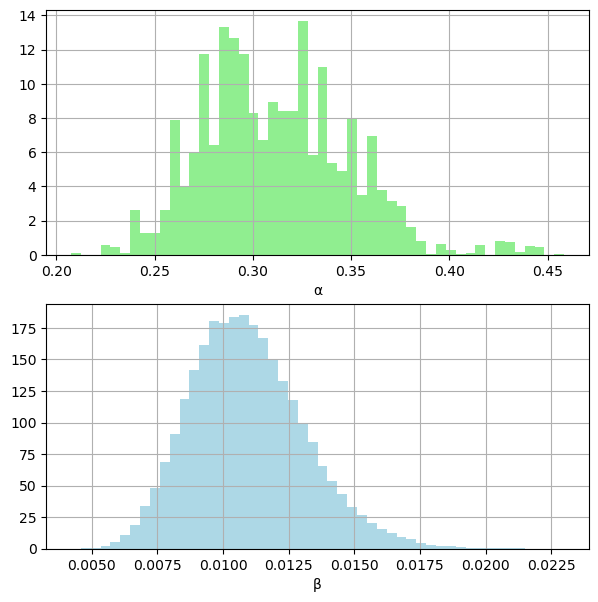

In [4]:
# posterior densities
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))

ax1.grid(True)
ax1.hist(alphas, color="lightgreen", density=True, bins=50)
ax1.set_xlabel("α")

ax2.grid(True)
ax2.hist(betas, color="lightblue", density=True, bins=50)
ax2.set_xlabel("β")

plt.show()

In [5]:
print(f"{np.mean(lambdas)=:.3f}")
print(f"{np.mean(alphas)=:.3f}")
print(f"{np.mean(betas)=:.3f}")

np.mean(lambdas)=29.205
np.mean(alphas)=0.312
np.mean(betas)=0.011


I didn't visualize the deaths by county, may add that later.

### Check results with PyMC

In [6]:
import arviz as az
import pymc as pm

In [7]:
with pm.Model() as m:
    alpha = pm.Uniform("alpha", 0, A)
    beta = pm.Uniform("beta", 0, B)

    lam = pm.Gamma("lam", alpha, beta, shape=y.shape[0])
    pm.Poisson("likelihood", mu=lam * n, observed=y)

    trace = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, lam]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 8 seconds.


In [8]:
az.summary(trace, hdi_prob=0.95, var_names=["alpha", "beta"])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.304,0.037,0.235,0.377,0.001,0.0,4705.0,7311.0,1.0
beta,0.011,0.002,0.007,0.016,0.000,0.0,7468.0,8732.0,1.0


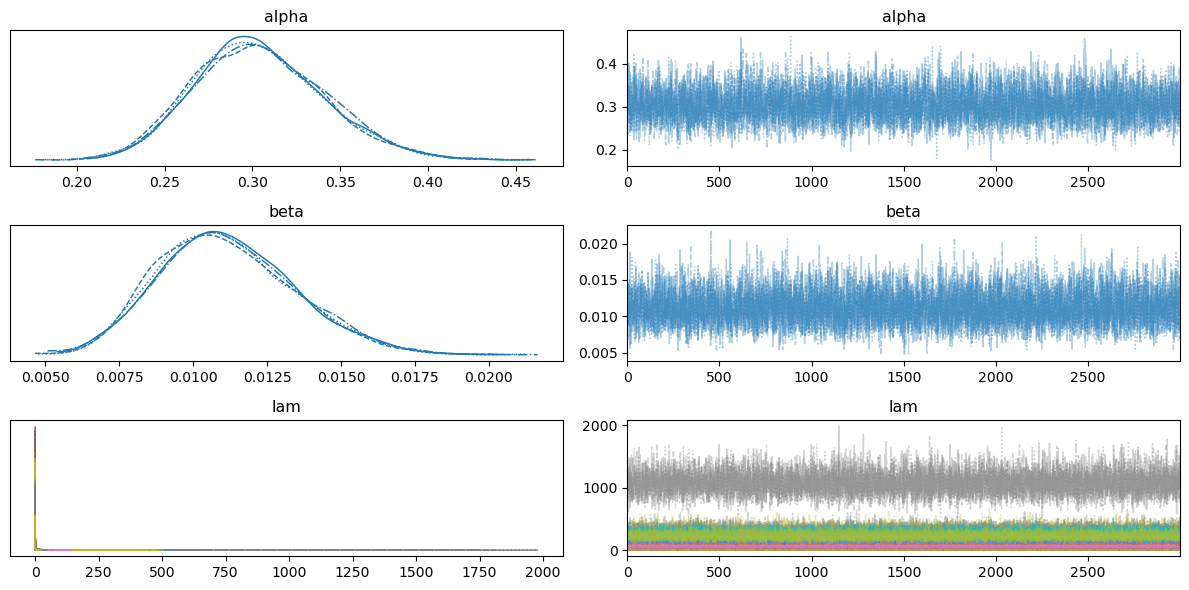

In [9]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

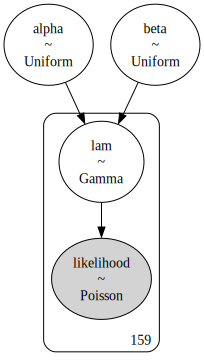

In [10]:
pm.model_to_graphviz(model=m)

In [11]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Sun Aug 20 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pymc      : 5.7.1
polars    : 0.18.11
arviz     : 0.16.1
numpy     : 1.24.4
matplotlib: 3.7.2

